In [1]:
import os
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
device

'cuda'

In [3]:
from google.colab import files
files.upload()  # Select and upload kaggle.json from your PC


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sohang576","key":"e59e238a416c68e6c10b0ab7eee5c286"}'}

In [4]:
# Create a directory and move kaggle.json there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install Kaggle CLI (if not already installed)
!pip install -q kaggle

# Download the Chest X-ray dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip it
!unzip -q chest-xray-pneumonia.zip


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.28G/2.29G [00:19<00:00, 277MB/s]
100% 2.29G/2.29G [00:21<00:00, 116MB/s]


In [5]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
train_dir = "chest_xray/train"
val_dir = "chest_xray/val"
test_dir = "chest_xray/test"

In [7]:
train_data = datasets.ImageFolder(train_dir, transform=transform_train)
val_data = datasets.ImageFolder(val_dir, transform=transform_val_test)
test_data = datasets.ImageFolder(test_dir, transform=transform_val_test)

In [8]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [9]:
class_names = train_data.classes
print("Classes:", class_names)


Classes: ['NORMAL', 'PNEUMONIA']


In [10]:
#making baltches:
BATCH_SIZE = 32
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)

In [11]:
from torchvision.models import resnet18
model_1 = resnet18(weights=None).to(device)

model_1.fc = nn.Linear(in_features = 512,
                       out_features = len(class_names)
                       ).to(device)

In [12]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)
train_accuracies = []
test_accuracies = []
train_loss = []
test_loss = []

In [16]:
from helper_functions import accuracy_fn
import torch.nn.functional as F
from tqdm.auto import tqdm

epochs1 = 5

for epoch1 in tqdm(range(epochs1)):
    train_loss1 = 0
    train_acc1 = 0

    for batch1, (X1, y1) in enumerate(train_dataloader):
        model_1.train()
        X1, y1 = X1.to(device), y1.to(device)

        y_pred1 = model_1(X1)

        loss1 = loss_fn(y_pred1, y1)
        probs1 = F.softmax(y_pred1, dim=1)
        train_loss1 += loss1

        optimizer.zero_grad()
        loss1.backward()
        optimizer.step()

        train_acc1 += accuracy_fn(y_true=y1, y_pred=probs1.argmax(dim=1))
        train_loss1 += loss1

    train_loss1 = train_loss1 / len(train_dataloader)
    train_acc1 = train_acc1 / len(train_dataloader)
    train_accuracies.append(train_acc1)
    train_loss.append(train_loss1)

    test_loss1, test_acc1 = 0, 0
    model_1.eval()

    with torch.inference_mode():
        for X2, y2 in test_dataloader:
            X2, y2 = X2.to(device), y2.to(device)
            test_pred1 = model_1(X2)
            test_probs1 = F.softmax(test_pred1, dim=1)

            test_loss1 += loss_fn(test_pred1, y2)
            test_acc1 += accuracy_fn(y_true=y2, y_pred=test_probs1.argmax(dim=1))

        test_loss1 /= len(test_dataloader)
        test_acc1 /= len(test_dataloader)
    #scheduler.step(test_acc1)
    test_accuracies.append(test_acc1)
    test_loss.append(test_loss1)
    if (epoch1 + 1) % 1 == 0:
        print(f"Epoch {epoch1+1}: ")
        print(f"Train loss: {train_loss1:.5f} | Train accuracy: {train_acc1:.2f}%")
        print(f"Test loss: {test_loss1:.5f} | Test accuracy: {test_acc1:.2f}%")
        print()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: 
Train loss: 0.23529 | Train accuracy: 95.57%
Test loss: 0.31708 | Test accuracy: 89.06%



KeyboardInterrupt: 

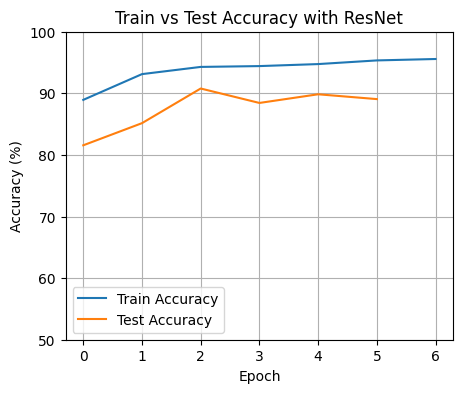

In [17]:
import matplotlib.pyplot as plt

# Plotting Train vs Test Accuracy
plt.figure(figsize=(5, 4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy with ResNet")
plt.ylim(50, 100)  # Set y-axis range
plt.legend()
plt.grid(True)
plt.show()


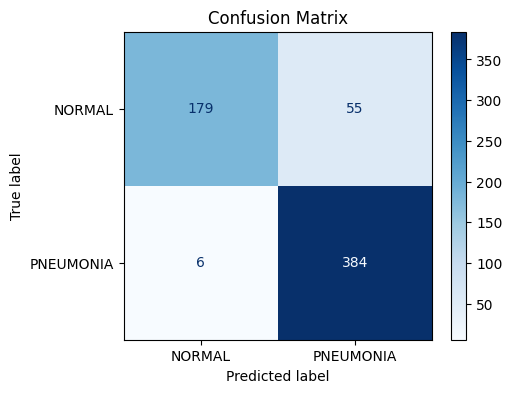

In [18]:
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns

y_true, y_pred =[],[]
model_1.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    test_pred = model_1(X)
    test_probs = F.softmax(test_pred, dim=1)
    y_true.append(y.cpu())
    y_pred.append(test_probs.argmax(dim=1).cpu())

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)

y_true
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(5, 4))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap="Blues")  # Pass the custom `ax` and optional colormap
plt.title("Confusion Matrix")
plt.show()

